# Step43, 신경망

이전 단계의 선형 회귀 코드를 수정하여 신경망으로 진화시킨다.  
우선 이전 단계에서 수행한 변환을 DeZero의 linear 함수로 구현하는 일부터 시작한다.

## 43.1 DeZero의 linear 함수 

이전 단계에서 구현한 선형회귀에서, 선형 회귀로 수행한 계산은 '행렬의 곱'과 '덧셈'뿐이었다.  
y = F.matmul(x,W) + b 

이 변환을 선형 변환(linear transformartion) 혹은 아핀 변환(affine transformartion)이라고 한다.

**NOTE_** 선형 변환은 신경망에서는 완전연결계층(fully connected layer)에 해당  
W 는 가중치(weight)  
b 는 편향(bias)

앞의 선형변환을 linear 함수로 구현한다. Function 클래스를 상속하여 새롭게 Linear라는 함수 클래스를 구현  
메모리를 더 효율적으로 쓴다.

하지만 클래스를 상속받지않고 선형변환을 함수화하면서 메모리를 효율적으로 쓰는 방법이 있다.  

matmul 함수의 출력 변수로 t가 있다.  
변수 t는 matmul 함수의 출력인 동시에 +(add 함수)의 입력이다.  
이 두 함수의 역전파를 생각해본다.

+의 역전파 : 출력 쪽의 기울기를 단순히 흘려보내기만 할 뿐이다. 즉, t의 데이터는 + 역전파에 필요하지 않다.  
matmul 역전파 : 입력 x, W, b만 사용. 따라서 matmul역전파 또한 t의 데이터를 필요로 하지 않는다.

--> 변수 t의 데이터는 역전파시 아무에게도 필요하지 않는다  
--> 기울기를 흘려보내야 하므로 계산 그래프에서는 변수 t가 필요하지만, 그 안의 데이터는 즉시 지워도 된다.



In [1]:
# functions.py 
def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b is None:
        return t 
    
    y = t + b 
    t.data = None   # t의 데이터 삭제 
    return y 


**NOTE_** 신경망에서 메모리의 대부분을 차지하는 것이 중간 계산 결과인 텐서이다.  
특히 큰 텐서를 취급하는 경우 ndarray 인스턴스가 거대해지므로 불필요한 ndarray 인스턴스는 즉시 삭제하는 것이 바람직하다.

## 43.2 비선형 데이터셋 


In [2]:
from dezero import Variable, as_variable, Function
import dezero.functions as F

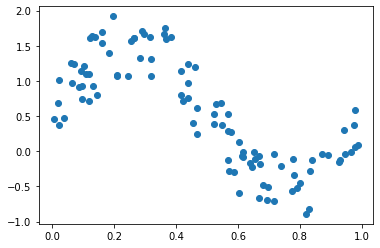

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100,1)

plt.scatter(x,y)
plt.show()

x와 y는 선형관계가 아니다. 비선형 데이터셋은 선형회귀로는 풀수 없다.  
신경망을 이용한다.

## 43.3 활성화 함수와 신경망  

신경망은 선형변환의 출력에 비선형 변환을 수행한다.  
이 비선형 변환을 활성화 함수(activation function)라고 한다.  
대표적으로 ReLU, sigmoid function 등이 있다.

여기에서는 활성화 함수로 시그모이드 함수를 사용해본다.

$$y = \frac{1}{1+exp(-x)}$$

In [4]:
class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y

    def backward(self, gy):
        y = self.outputs[0]()  # weakref
        gx = gy * y
        return gx


def exp(x):
    return Exp()(x)

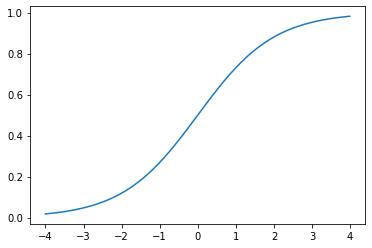

In [5]:
import dezero.functions as F

# functions.py
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y 

x = np.arange(-4, 4, .01)
y = sigmoid_simple(x)
plt.plot(x, y.data)
plt.show()

**NOTE_** 여기에서 제시한 시그모이드 함수 코드는 메모리 효율이 좋지 않다.  
더 나은 방식은 Function 클래스를 상속한 Sigmoid 클래스를 구현하는 것이다.  
또한 시그모이드 함수의 경우 클래스를 하나의 단위로 하여 기울기 계산 효율을 높일 수 있다.

In [6]:
# functions.py 
class Sigmoid(Function):
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * y * (1 - y)
        return gx


def sigmoid(x):
    return Sigmoid()(x)

## 43.4 신경망 구현 

일반적인 신경망은  
'(선형 변환 -> 활성화 함수) -> (선형 변환 -> 활성화 함수) -> (선형 변환 -> 활성화 함수) -> ...' 형태로 연속적으로 변환을 수행 

2층신경망은 다음처럼 구현할 수 있다.

~~~python 
W1, b1 = Variable(...), Variable(...)
W2, b2 = Variable(...), Variable(...) 

def predict(x):
    y = F.linear(x, W1, b1) # 또는 F.linear_simple(...)
    y = F.sigmoid(y)        # 또는 F.sigmoid_simple(y)
    y = linear(y, W2, b2)
    return y
~~~

이와 같이 '선형 변환'과 '활성화 함수'를 순서대로 적용  
이것이 신경망 추론(predict)코드이다.  
추론을 제대로 하려면 '학습'이 필요하다.  
신경망 학습에서는 추론을 처리한 후 손실 함수를 추가하고 손실 함수의 출력을 최소화하는 매개변수를 찾는다.  
이것이 신경망의 학습이다.

데이터셋을 활용하여 신경망을 학습시켜본다.

variable(0.8473775609040177)
variable(0.2525860177408473)
variable(0.2508400017812953)
variable(0.24862974457100465)
variable(0.24399991205860405)
variable(0.22903492757925054)
variable(0.19180555738801783)
variable(0.12083907842470873)
variable(0.08046540763698416)
variable(0.0774738350881417)


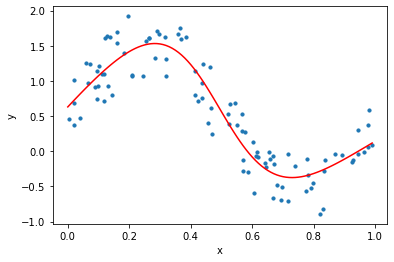

In [7]:
import numpy as np 
from dezero import Variable
import dezero.functions as F 
import matplotlib.pyplot as plt

# 데이터셋 
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 1. 가중치 초기화 
I, H, O = 1, 10, 1
W1 = Variable(0.001 * np.random.randn(I,H))    # 입력 x가 (100,1)이니깐 (1,10) 1로 맞추고 10개 출력
b1 = Variable(np.zeros(H))                          # 출력 10개에 10개 bias를 더함
W2 = Variable(0.01 * np.random.randn(H,O))       # (10,1) 
b2 = Variable(np.zeros(O))

# 2. 신경망 추론 
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y 

lr = 0.2 
iters = 10000

# 3. 신경망 학습 
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data 
    b1.data -= lr * b1.grad.data 
    W2.data -= lr * W2.grad.data 
    b2.data -= lr * b2.grad.data 
    if i % 1000 == 0:
        print(loss)

# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

variable(0.8473695850105871)
variable(0.25142862851836056)
variable(0.24759485466749864)
variable(0.23786120447054798)
variable(0.21222231333102898)
variable(0.16742181117834126)
variable(0.09681932619992634)
variable(0.07849528290602327)
variable(0.07749729552991153)
variable(0.07722132399559314)


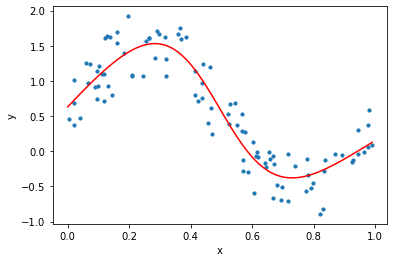

In [8]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F


np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))


def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y


lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)


# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()